# Table representation

This Notebook compares the size of table representations for the most common table structures.

Representation used are CSV, JSON, CBOR (binary json), PARQUET

## tree and multidimensional patterns

Tables contain to kind of columns:

- variables (values) : columns with unstructured data
- indexes (coordinates, dimensions) : columns with data used to select, group or filter variables data

Two basic patterns are present in indexes :

- Tree pattern: A tree is represented in tabular form by a list of paths between each leaf and the node. The columns then represent the levels of the tree and the values represent the nodes of the tree.
- Multidimensional pattern: A matrix (or multidimensional data) is represented in tabular form by a column of the values of the matrix and additional columns represent the coordinates of each of the values.

Table 1 presents an example of binary tree.

| Root | level 1 | level 2 | value |
|------|---------|---------|-------|
| A    | B       | D       |1      |
| A    | B       | E       |2      |
| A    | C       | F       |3      |
| A    | C       | G       |4      |

*Table 1: Tree pattern*

Table 2 presents an example of matrix

| row | col | Value |
|-----|-----|-------|
| A   | C   | 1     |
| A   | D   | 2     |
| B   | C   | 3     |
| B   | D   | 4     |

*Table 2: Multidimensional pattern*

In the general case, Datasets mix these two structures.

Taking these structures into account in JSON representation leads to significant duplication of data. 

In [59]:
import random
import string
import json
import xarray as xr
import pandas as pd
import numpy as np
from ntv_numpy import Xdataset
import ntv_pandas as npd
import cbor2
import matplotlib.pyplot as plt

In [98]:
np.arange(3, dtype=None)

array([0, 1, 2])

## multidimensional data

### example

This example is a Dataset with three dimensions and each dimension has two values. The variable contains also eight values.

The JSON representation for multidimensional data don't duplicate indexes values.

In [153]:

def coords_int(val, leng):
    return np.arange(val, val+leng)

def coords_str(leng):
    return np.array([''.join(random.choices(string.ascii_letters, k=12)) for _ in range(leng)])

def variable(nb, dim):
    return np.arange(nb**dim).reshape([nb] * dim)
    
dimensions = 3   
fields = ['dim_' + str(i) for i in range(dimensions)]

nb1 = 2
xds = xr.Dataset({"var": (fields, variable(nb1, dimensions))}, 
                   coords={field: coords_int(val*nb1, nb1) for val, field in enumerate(fields)})

df = Xdataset.from_xarray(xds).to_dataframe(ntv_type=False, info=False).reset_index()
df

,dim_0,dim_1,dim_2,var
0,0,2,4,0
1,0,2,5,1
2,0,3,4,2
3,0,3,5,3
4,1,2,4,4
5,1,2,5,5
6,1,3,4,6
7,1,3,5,7


In [161]:
Xdataset.from_xarray(xds).to_json(notype='all', header=False, encoded=False)
Xdataset.from_dataframe(df).to_json(notype='all', header=False, encoded=False)

{'idx_0': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]],
 'idx_1': [['idx_0'], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]],
 'idx_2': [['idx_1'], [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]],
 'idx_3': [['idx_2'], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]],
 'idx_4': [[0]]}

### size comparison
Five formats are compared:

- JSON DataFrame (`values` option)
- CSV
- PARQUET
- JSON Xdataset (JSON for tabular and multidimensional data)
- CBOR Xdataset (binary JSON format)

and four datasets :

- five dimensions and four integer values per dimension
- five dimensions and four string values per dimension
- five dimensions and ten integer values per dimension
- five dimensions and ten string values per dimension

In [109]:
dimensions = 5    
fields = ['dim_' + str(i) for i in range(dimensions)]

nb1 = 4
nb2 = 10
xdss = [xr.Dataset({"var": (fields, variable(nb1, dimensions))}, 
                   coords={field: coords_int(val*nb1, nb1) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, variable(nb1, dimensions))}, 
                   coords={field: coords_str(nb1) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, variable(nb2, dimensions))}, 
                   coords={field: coords_int(val*nb2, nb2) for val, field in enumerate(fields)}),
        xr.Dataset({"var": (fields, variable(nb2, dimensions))}, 
                   coords={field: coords_str(nb2) for val, field in enumerate(fields)})] #,

Xdataset.from_xarray(xdss[2]).to_dataframe(ntv_type=False, info=False).reset_index()

,col_0,col_1,col_2,col_3,col_4,var
0,0,10,20,30,40,0
1,0,10,20,30,41,1
2,0,10,20,30,42,2
3,0,10,20,30,43,3
4,0,10,20,30,44,4
...,...,...,...,...,...,...
99995,9,19,29,39,45,99995
99996,9,19,29,39,46,99996
99997,9,19,29,39,47,99997
99998,9,19,29,39,48,99998


In [144]:
def file_sizes(xnd, forma={}):
    '''calculate the size of each format'''
    df = xnd.to_dataframe(json_name=False, info=False).reset_index().sample(frac=1)
    jsn = xnd.to_json(notype='all', header=False, encoded=False, format=forma)
    return {'pd.to_json(values)': len(df.to_json(orient='values')),
            'pd.to_csv': len(df.to_csv()),
            'pd.to_parquet': len(df.to_parquet(engine='pyarrow')),
            'xnd.to_json': len(json.dumps(jsn)),
            'xnd.to_json(cbor)': len(cbor2.dumps(jsn))}

def sizes_plot(sizes, titles, fig_title):
    '''plot the size of some format''' 
    fig, axs = plt.subplots(2, 2, figsize=(11, 6), sharex="col")
    fig.suptitle(fig_title)
    for idx, (size, title) in enumerate(zip(sizes, titles)):
        bar_colors = ['tab:red' if val == min(size.values()) else 'tab:blue' for val in size.values()]
        percent = [str(round(val / list(size.values())[1] * 100, 1)) + ' %' for val in size.values()]
        bar_plt = axs[idx//2][idx%2].bar(size.keys(), size.values(), color=bar_colors)
        axs[idx//2][idx%2].set_title(title)
        axs[idx//2][idx%2].bar_label(bar_plt, percent, label_type='center')
        if idx//2:
            axs[idx//2][idx%2].tick_params(axis='x', rotation=70)
    plt.show()

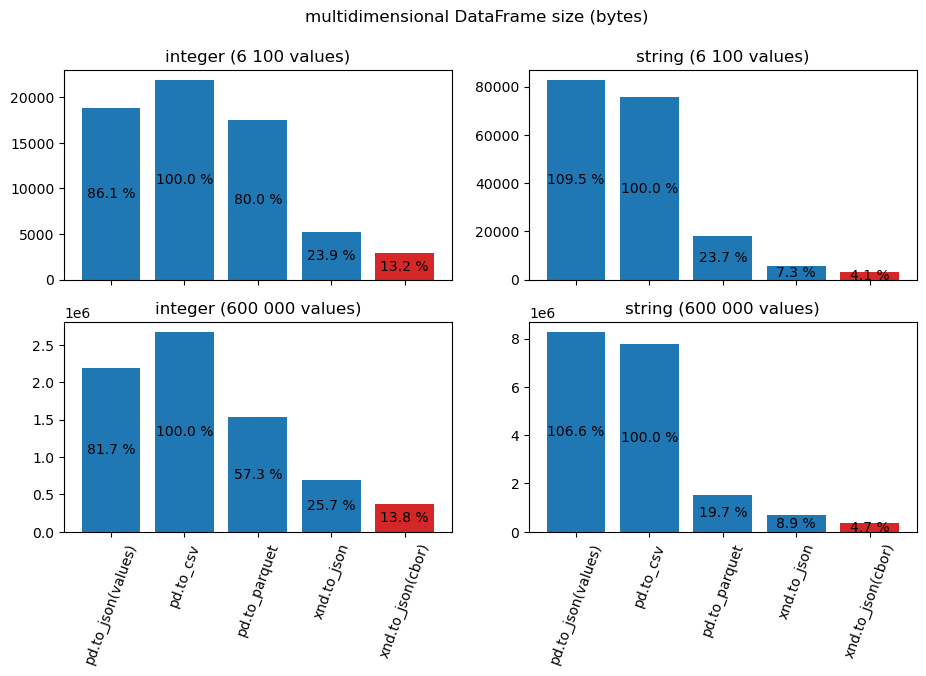

In [145]:
xnds = [Xdataset.from_xarray(xds) for xds in xdss]
sizes = [file_sizes(xnd) for xnd in xnds]
titles = ['integer (6 100 values)', 'string (6 100 values)', 'integer (600 000 values)', 'string (600 000 values)']
sizes_plot(sizes, titles, 'multidimensional DataFrame size (bytes)')

## tree data

### example

This example is a Dataset with five tree levels and each node has two child nodes. The variable contains also eight values.

The JSON representation for multidimensional data don't duplicate indexes values.

In [156]:
def data_int_str(size):
    arr = np.arange(2**size)
    data_int = [arr]
    data_str = [np.frompyfunc(str, 1, 1)(arr)]
    for i in range(size):
        arr = arr // 2
        data_int.append(arr)
        data_str.append(np.frompyfunc(str, 1, 1)(arr))
    field_names = ['idx_' + str(i) for i in range(len(data_int))]
    return [data_int, data_str, field_names]   

size1 = 4
data_set = data_int_str(size1)[:2] + data_int_str(size2)[:2]
names_set= [data_int_str(size1)[2]] * 2 + [data_int_str(size2)[2]] * 2

In [158]:
df = pd.DataFrame({field: data for field, data in zip (data_int_str(size1)[2], data_int_str(size1)[0])})
df

,idx_0,idx_1,idx_2,idx_3,idx_4
0,0,0,0,0,0
1,1,0,0,0,0
2,2,1,0,0,0
3,3,1,0,0,0
4,4,2,1,0,0
5,5,2,1,0,0
6,6,3,1,0,0
7,7,3,1,0,0
8,8,4,2,1,0
9,9,4,2,1,0


In [165]:
forma = {name:'complete' for name in df.columns[1:]}
Xdataset.from_dataframe(df).to_json(notype='all', header=False, encoded=False, format=forma)


{'idx_0': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]],
 'idx_1': [['idx_0'],
  [[0, 1, 2, 3, 4, 5, 6, 7],
   [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7]]],
 'idx_2': [['idx_1'], [[0, 1, 2, 3], [0, 0, 1, 1, 2, 2, 3, 3]]],
 'idx_3': [['idx_2'], [[0, 1], [0, 0, 1, 1]]],
 'idx_4': [[0]]}

In [87]:
size1 = 9
size2 = 14
data_set = data_int_str(size1)[:2] + data_int_str(size2)[:2]
names_set= [data_int_str(size1)[2]] * 2 + [data_int_str(size2)[2]] * 2

In [88]:
df_list = [pd.DataFrame({field: data for field, data in zip (field_names, data_list)}) for field_names, data_list in zip(names_set, data_set)]

df_list[2]

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,16379,8189,4094,2047,1023,511,255,127,63,31,15,7,3,1,0
16380,16380,8190,4095,2047,1023,511,255,127,63,31,15,7,3,1,0
16381,16381,8190,4095,2047,1023,511,255,127,63,31,15,7,3,1,0
16382,16382,8191,4095,2047,1023,511,255,127,63,31,15,7,3,1,0


In [89]:
xnds = [Xdataset.from_dataframe(df) for df in df_list]

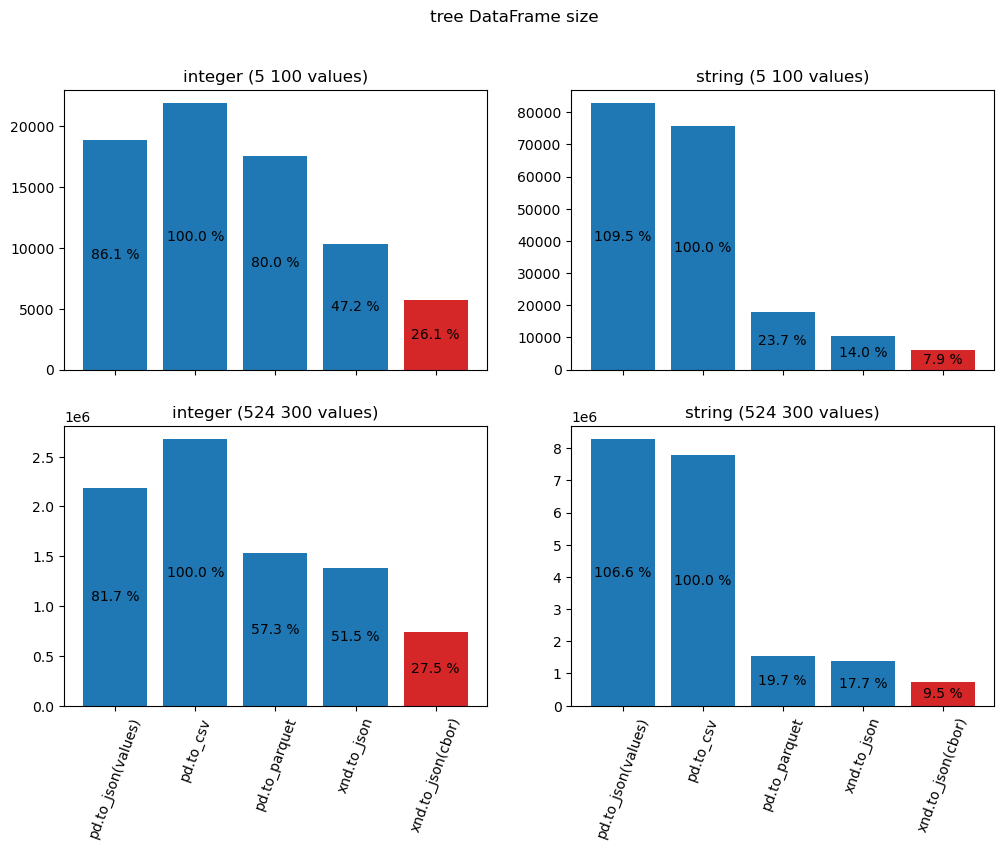

In [141]:
forma = [{name:'complete' for name in xnd.names[1:]} for xnd in xnds]
sizes = [file_sizes(xnd, form) for xnd, form in zip(xnds, forma)]
titles = ['integer (5 100 values)', 'string (5 100 values)', 'integer (524 300 values)', 'string (524 300 values)']
sizes_plot(sizes, titles, 'tree DataFrame size (bytes)')